In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.patches import Patch

plt.style.use('default')
sns.set_palette("husl")

In [7]:
# Load TCGA data files using the same variable names structure
data_mrna_seq_rpkm_tcga = pd.read_csv('tcga_data/data_mrna_seq_fpkm.txt', sep='\t', comment='#')
data_mrna_seq_rpkm_tcga.set_index('Hugo_Symbol', inplace=True)
data_mrna_seq_rpkm_tcga = data_mrna_seq_rpkm_tcga.groupby(data_mrna_seq_rpkm_tcga.index).mean()

mutations_tcga = pd.read_csv('tcga_data/mutations.txt', sep='\t', comment='#')
mutations_tcga.set_index('SAMPLE_ID', inplace=True)

data_mutations_tcga = pd.read_csv('tcga_data/data_mutations.txt', sep='\t', comment='#')
data_mutations_tcga = data_mutations_tcga[data_mutations_tcga['Hugo_Symbol'] == 'TP53']
data_mutations_tcga = data_mutations_tcga[['Tumor_Sample_Barcode', 'Variant_Type']]
data_mutations_tcga.set_index('Tumor_Sample_Barcode', inplace=True)

# Prepare aligned datasets for TCGA using your approach
data_t_tcga = data_mrna_seq_rpkm_tcga.T

# Build target vector y and aligned expression matrix X for TCGA
y_tcga = []
X_rows_tcga = []
sample_names_tcga = []
c_tcga = 0

# iterate over each mutation record
for bc, mut in data_mutations_tcga.iterrows():
    # check if this barcode is in data_t_tcga's index
    if bc in data_t_tcga.index:
        # grab the full row from data_t_tcga and store it
        X_rows_tcga.append(data_t_tcga.loc[bc].values)
        y_tcga.append(mut['Variant_Type'])
        sample_names_tcga.append(bc)
    else:
        c_tcga += 1

print(f"TCGA Number of samples discarded: {c_tcga}")

# build a new DataFrame X from the collected rows
X_tcga = pd.DataFrame(X_rows_tcga, index=sample_names_tcga, columns=data_t_tcga.columns)
y_tcga = np.array(y_tcga)

print(f"TCGA Original gene expression data shape: {data_mrna_seq_rpkm_tcga.shape}")
print(f"TCGA Original mutations data shape: {mutations_tcga.shape}")
print(f"TCGA TP53 mutations data shape: {data_mutations_tcga.shape}")
print(f"TCGA Final aligned expression data shape: {X_tcga.shape}")
print(f"TCGA Final aligned mutation data length: {len(y_tcga)}")
print(f"TCGA Unique mutation types: {np.unique(y_tcga)}")

TCGA Number of samples discarded: 510
TCGA Original gene expression data shape: (55851, 1210)
TCGA Original mutations data shape: (2683, 2)
TCGA TP53 mutations data shape: (941, 1)
TCGA Final aligned expression data shape: (431, 55851)
TCGA Final aligned mutation data length: 431
TCGA Unique mutation types: ['DEL' 'DNP' 'INS' 'SNP']


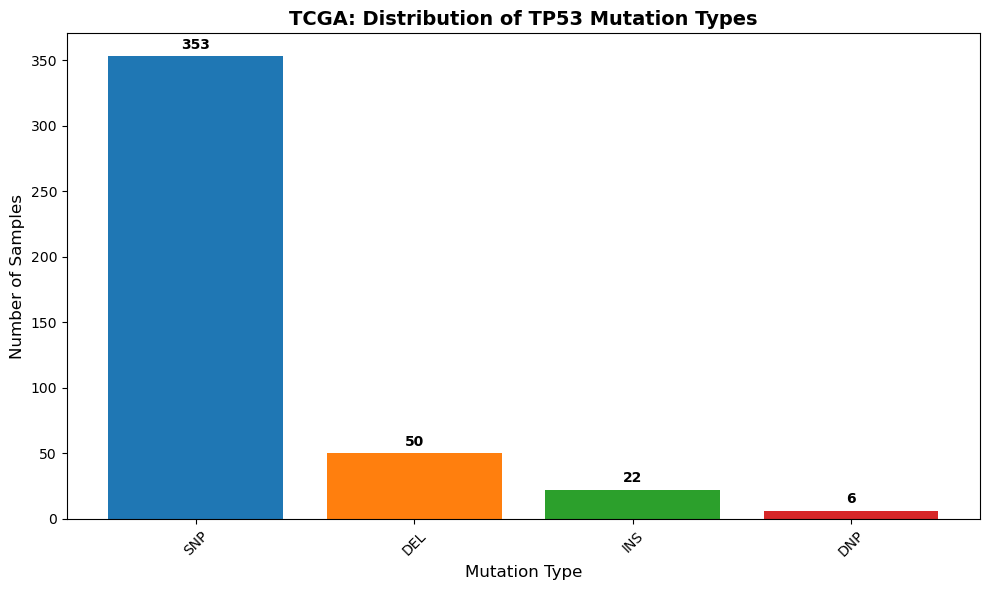

TCGA TP53 Mutation distribution:
SNP: 353 (81.9%)
DEL: 50 (11.6%)
INS: 22 (5.1%)
DNP: 6 (1.4%)


In [8]:
# Class Distribution Plot for TCGA
plt.figure(figsize=(10, 6))
mutation_counts_tcga = pd.Series(y_tcga).value_counts()

bars = plt.bar(mutation_counts_tcga.index, mutation_counts_tcga.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('TCGA: Distribution of TP53 Mutation Types', fontsize=14, fontweight='bold')
plt.xlabel('Mutation Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)

# Add count labels on bars
for bar, count in zip(bars, mutation_counts_tcga.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mutation_counts_tcga.values)*0.01, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("TCGA TP53 Mutation distribution:")
for mut_type, count in mutation_counts_tcga.items():
    percentage = (count / mutation_counts_tcga.sum()) * 100
    print(f"{mut_type}: {count} ({percentage:.1f}%)")

/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1600x1000 with 0 Axes>

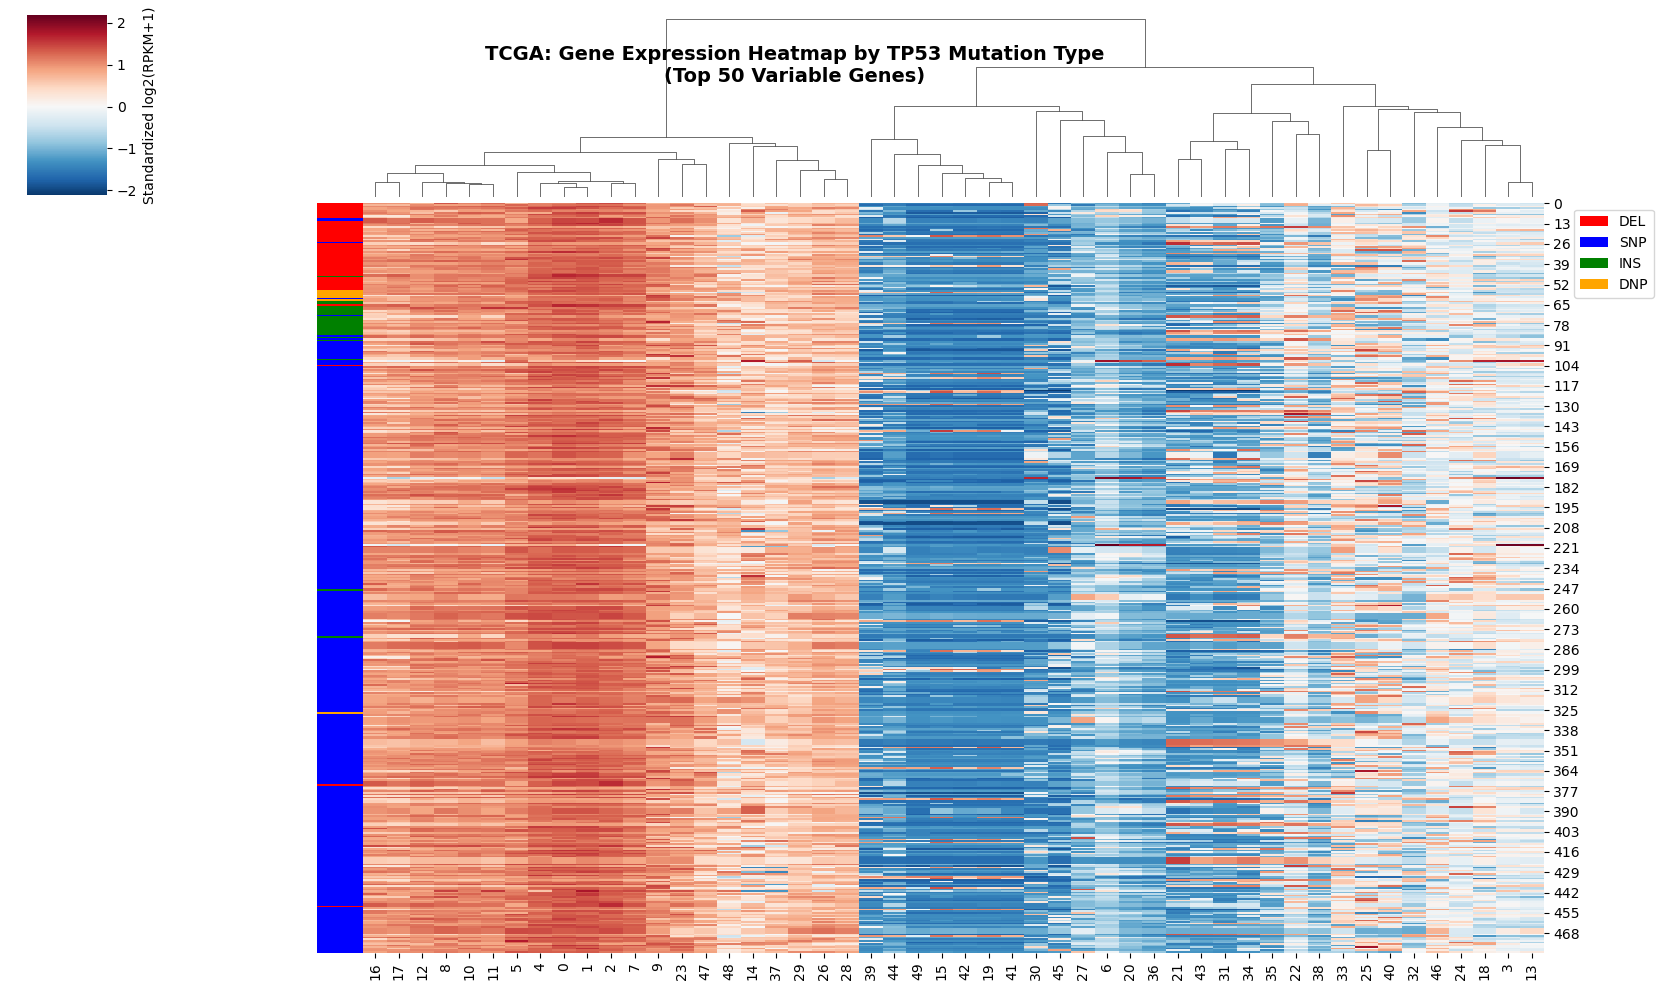

In [9]:
# TCGA Expression Heatmap using aligned data
# Select top 50 most variable genes
gene_variance_tcga = X_tcga.var(axis=0).sort_values(ascending=False)
top_genes_tcga = gene_variance_tcga.head(50).index
expr_heatmap_tcga = X_tcga[top_genes_tcga]

# Create mutation series for sorting
mut_series_tcga = pd.Series(y_tcga, index=X_tcga.index)
sorted_samples_tcga = mut_series_tcga.sort_values().index
expr_heatmap_sorted_tcga = expr_heatmap_tcga.loc[sorted_samples_tcga]
mut_colors_tcga = mut_series_tcga.loc[sorted_samples_tcga]

# Create color mapping for mutations
unique_mutations_tcga = mut_colors_tcga.unique()
color_map_tcga = dict(zip(unique_mutations_tcga, ['red', 'blue', 'green', 'orange'][:len(unique_mutations_tcga)]))
row_colors_tcga = [color_map_tcga[mut] for mut in mut_colors_tcga]

# Log transform and standardize
expr_log_tcga = np.log2(expr_heatmap_sorted_tcga + 1)
expr_std_tcga = StandardScaler().fit_transform(expr_log_tcga.T).T

# Create the heatmap
plt.figure(figsize=(16, 10))
g_tcga = sns.clustermap(expr_std_tcga, 
                       row_cluster=False, 
                       col_cluster=True,
                       row_colors=row_colors_tcga,
                       cmap='RdBu_r',
                       center=0,
                       figsize=(16, 10),
                       cbar_kws={'label': 'Standardized log2(RPKM+1)'})

g_tcga.fig.suptitle('TCGA: Gene Expression Heatmap by TP53 Mutation Type\n(Top 50 Variable Genes)', 
                   fontsize=14, fontweight='bold', y=0.95)

# Add legend for mutation types
legend_elements_tcga = [Patch(facecolor=color_map_tcga[mut], label=mut) for mut in unique_mutations_tcga]
g_tcga.ax_heatmap.legend(handles=legend_elements_tcga, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.show()

TCGA PCA input shapes - X: (431, 55851), y: (431,)


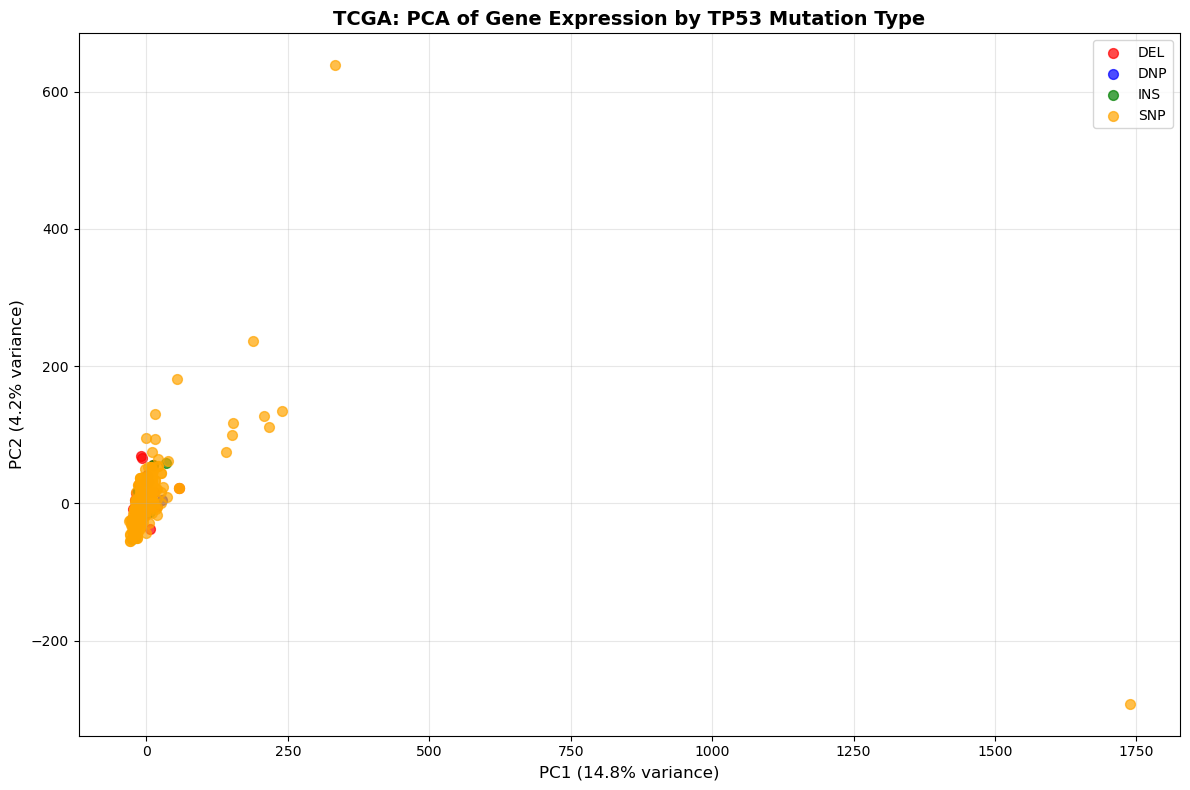

TCGA Total variance explained by PC1 and PC2: 19.0%


In [10]:
# TCGA PCA Analysis using aligned data
X_pca_tcga = X_tcga.values
y_pca_tcga = y_tcga

print(f"TCGA PCA input shapes - X: {X_pca_tcga.shape}, y: {y_pca_tcga.shape}")

# Apply PCA
scaler_tcga = StandardScaler()
X_scaled_tcga = scaler_tcga.fit_transform(X_pca_tcga)
pca_tcga = PCA(n_components=2)
X_pca_transformed_tcga = pca_tcga.fit_transform(X_scaled_tcga)

# Create PCA plot
plt.figure(figsize=(12, 8))
colors_tcga = ['red', 'blue', 'green', 'orange']
mutation_types_tcga = np.unique(y_pca_tcga)

for i, mut_type in enumerate(mutation_types_tcga):
    mask = y_pca_tcga == mut_type
    plt.scatter(X_pca_transformed_tcga[mask, 0], X_pca_transformed_tcga[mask, 1], 
                c=colors_tcga[i], label=mut_type, alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca_tcga.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca_tcga.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('TCGA: PCA of Gene Expression by TP53 Mutation Type', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"TCGA Total variance explained by PC1 and PC2: {pca_tcga.explained_variance_ratio_[:2].sum():.1%}")

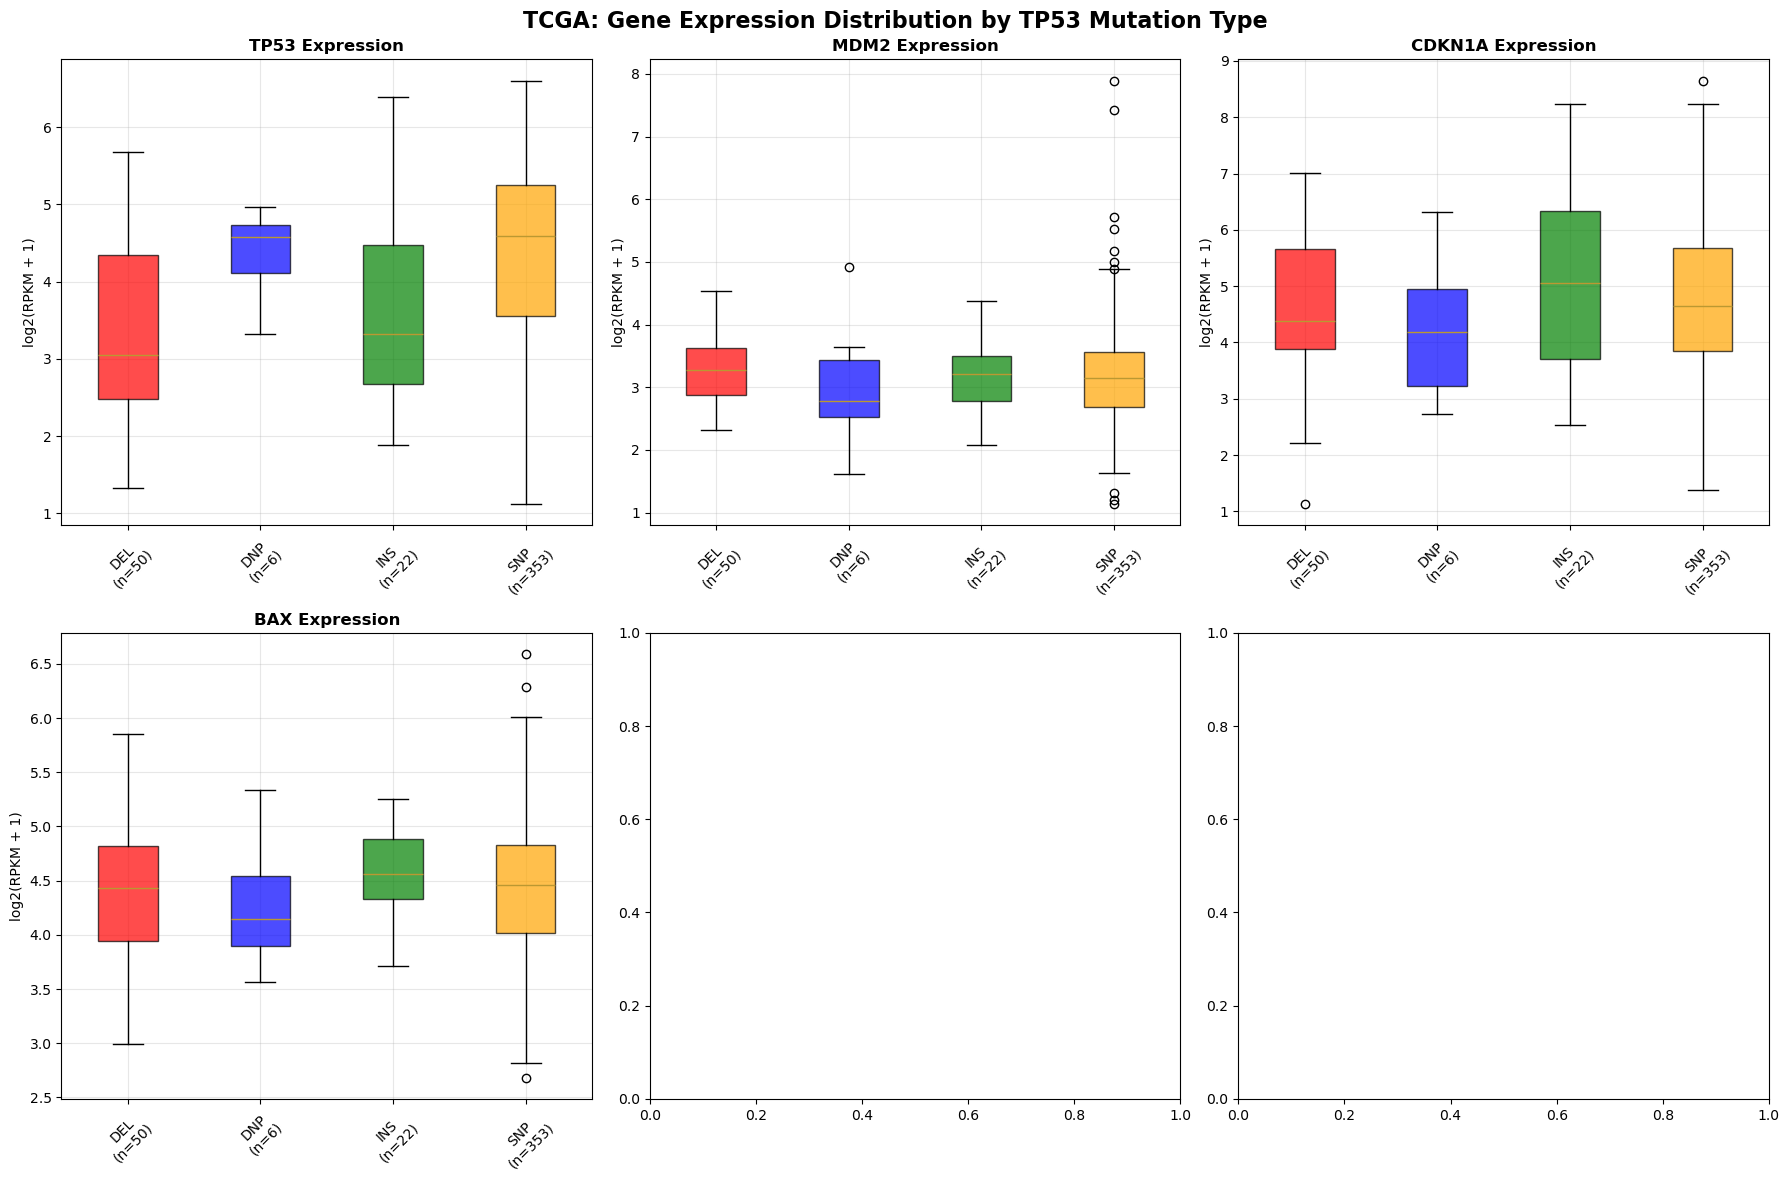

In [11]:
# TCGA Expression distribution analysis for key genes using aligned data
key_genes_tcga = ['TP53', 'MDM2', 'CDKN1A', 'BAX', 'PUMA']  # TP53 pathway genes
available_genes_tcga = [gene for gene in key_genes_tcga if gene in X_tcga.columns]

if len(available_genes_tcga) < 3:
    # If TP53 pathway genes not available, use top variable genes
    available_genes_tcga = gene_variance_tcga.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, gene in enumerate(available_genes_tcga[:6]):
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    for mut_type in mutation_types_tcga:
        mask = y_pca_tcga == mut_type
        gene_expr = X_tcga[gene].values[mask]
        plot_data.append(np.log2(gene_expr + 1))  # Log transform
        labels.append(f"{mut_type}\n(n={np.sum(mask)})")
    
    # Create box plot
    bp = axes[i].boxplot(plot_data, labels=labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors_tcga[:len(plot_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[i].set_title(f'{gene} Expression', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('log2(RPKM + 1)', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('TCGA: Gene Expression Distribution by TP53 Mutation Type', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()